## 1. Imports


In [1]:
import sys
import gc
import os
import random

import torch
from torch.utils.data import Subset
import torchvision.datasets as datasets
import numpy as np
from diffusers import DDIMScheduler
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

sys.path.append("..")
from utils import (
    set_random_seed,
    add_ddim_noise_at_t_step,
    add_ddim_noise_t_times,
    qiuck_ddim_noise_t_times,
    get_ddim_path,
    get_ddib_path,
    cod_prob_bound,
    estimate_cod_prob_bound,
)

from sampler import get_paired_dataset

%matplotlib inline 

## 2. Config


In [2]:
SEED = 0x4090
set_random_seed(SEED)

# dataset choosing
# DATASET, DATASET_PATH, IMG_SIZE, GRAY = "mnist2usps", "./data/", 28, True
DATASET, DATASET_PATH, IMG_SIZE, GRAY = "fmnist2mnist", "./data/", 28, True
# DATASET, DATASET_PATH, IMG_SIZE, GRAY = "usps2fmnist", "./data/", 28, True


# DATASET, DATASET_PATH, IMG_SIZE, GRAY = (
#     "comic_faces_v1",
#     "./data/face2comics_v1.0.0_by_Sxela",
#     256,
#     False,
# )

# the step number adding noise in diffusion process
DIFFUSION_STEPS = 100
SCHEDULER = DDIMScheduler(num_train_timesteps=DIFFUSION_STEPS)
PIVOTAL_LIST = [i for i in range(0, DIFFUSION_STEPS * 2 + 1, 100)]
# PIVOTAL_LIST = [20, 50, 100]
# All hyperparameters below is set to the values used for the experiments, which discribed in the article
EPSILON = 0.25
R = 1000  # or len(dataset) dataset estimation sample size
N = 2
P = 1
NUM_QUERY = 100
# data sample settings
SELECTED_CLASSES = [2]

## 3. Initialize dataset


In [3]:
class PairedDataset2(torch.utils.data.Dataset):
    def __init__(
        self,
        name,
        root,
        train=True,
        transform=None,
        download=False,
        selected_classes=None,
        reverse=False,
    ):
        super().__init__()
        self.reverse = reverse

        if name == "usps2fmnist":
            source = datasets.USPS(
                os.path.join(root, "USPS", "raw"), train, transform, download=download
            )
            target = datasets.FashionMNIST(root, train, transform, download=download)
        elif name == "fmnist2mnist":
            source = datasets.FashionMNIST(root, train, transform, download=download)
            target = datasets.MNIST(root, train, transform, download=download)
        elif name == "mnist2usps":
            source = datasets.MNIST(root, train, transform, download=download)
            target = datasets.USPS(
                os.path.join(root, "USPS", "raw"), train, transform, download=download
            )
        else:
            raise "Invalid dataset name"

        if selected_classes is not None:
            source_indices = [
                i for i in range(len(source)) if source.targets[i] in selected_classes
            ]
            target_indices = [
                i for i in range(len(target)) if target.targets[i] in selected_classes
            ]
        else:
            source_indices = range(len(source))
            target_indices = range(len(target))

        source_indices = source_indices[: min(len(source), len(target))]
        target_indices = target_indices[: min(len(source), len(target))]

        self.x = Subset(source, source_indices)
        self.y = Subset(target, target_indices)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x, y = (self.x)[idx][0], (self.y)[idx][0]

        return (x, y) if not self.reverse else (y, x)

In [4]:
if DATASET in ["mnist2fmnist", "usps2mnist", "fmnist2usps"]:
    transform = Compose(
        [
            Resize((IMG_SIZE, IMG_SIZE)),
            ToTensor(),
            Normalize((0.5), (0.5)),
        ]
    )
    dataset = PairedDataset2(
        DATASET,
        DATASET_PATH,
        transform=transform,
        selected_classes=SELECTED_CLASSES,
    )

elif DATASET == "comic_faces_v1":
    transform = Compose(
        [
            Resize((IMG_SIZE, IMG_SIZE)),
            ToTensor(),
            Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
    dataset, _ = get_paired_dataset(
        DATASET,
        DATASET_PATH,
        transform,
    )
else:
    raise "Invalid dataset"

len(dataset)

5958

In [5]:
type(dataset[0][0]), dataset[0][0].shape

(torch.Tensor, torch.Size([1, 28, 28]))

In [6]:
dataset = Subset(
    dataset,
    random.choices(range(len(dataset)), k=min(R, len(dataset))),
)
len(dataset)


1000

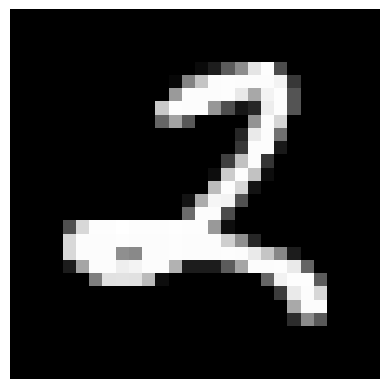

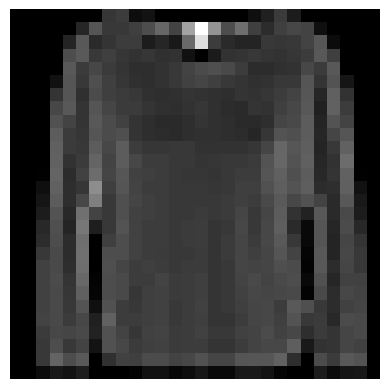

In [7]:
def plot_data_point(x, gray=GRAY):
    if gray:
        plt.imshow(x.squeeze().numpy(), cmap="gray")
    else:
        plt.imshow(x.squeeze().permute(1, 2, 0).numpy())
    plt.axis("off")  # 不显示坐标轴
    plt.show()


plot_data_point(dataset[0][0])
plot_data_point(dataset[0][1])

In [8]:
from typing import Union


def plot_path(
    path: Union[list, torch.Tensor],
    indices: list = None,
    gray: bool = False,
):
    if indices is not None:
        path = [path[i] for i in indices]
    if isinstance(path, list):
        path = torch.stack(path)

    imgs: np.ndarray = (
        path.to("cpu").permute(0, 2, 3, 1).mul(0.5).add(0.5).numpy().clip(0, 1)
    )

    if len(path) < 10:
        ncols = len(path)
        nrows = 1
    else:
        ncols = 10
        nrows = len(path) // 10 + 1

    fig = plt.figure(figsize=(1.5 * ncols, 1.5 * nrows), dpi=150)
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(nrows, ncols, i + 1)
        if gray:
            ax.imshow(img, cmap="gray")
        else:
            ax.imshow(img)
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_title(f"$X_{{{i}}}$", fontsize=16)
        if i == imgs.shape[0] - 1:
            ax.set_title("Y", fontsize=16)
    fig.tight_layout()
    torch.cuda.empty_cache()
    gc.collect()

## 4. Concentration of Distance Probability


### DDIB


#### generate asymptotic distribution


In [9]:
image_shape = dataset[0][0].shape

In [10]:
# FIXME: 512图片内存占用巨大，需要优化（或者服务器运行尝试）

In [11]:
x2self_prob_bound = None
y2self_prob_bound = None

x2y_prob_bound = None
x2g_ddim_prob_bound_list = []
x2g_prob_bound = None
g2y_ddim_prob_bound_list = []
g2y_prob_bound = None

Q_point_indices = np.random.choice(len(dataset), NUM_QUERY, replace=False)


In [12]:
x2y_ddib_asymptotic_neighbor_dataset = torch.empty(
    (2, len(dataset), *image_shape), dtype=torch.float32
)


In [13]:
for i in tqdm(range(len(dataset))):
    x2y_ddib_asymptotic_neighbor_dataset[0][i] = dataset[i][0]
    x2y_ddib_asymptotic_neighbor_dataset[1][i] = dataset[i][1]


  0%|          | 0/1000 [00:00<?, ?it/s]

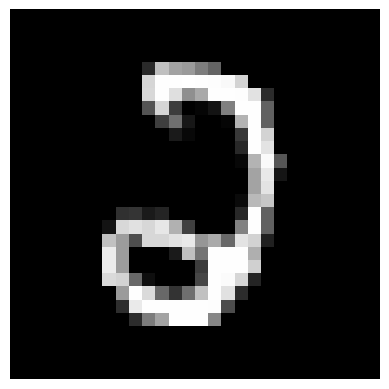

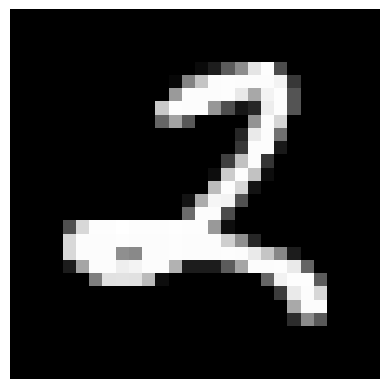

x -> x: P{DMAX(2)<=(1+0.25)DMIN(2)}>=1.3813%


In [14]:
Q_dataset = x2y_ddib_asymptotic_neighbor_dataset[0][Q_point_indices]
T_dataset = x2y_ddib_asymptotic_neighbor_dataset[0]

plot_data_point(Q_dataset[0])
plot_data_point(T_dataset[0])

prob_bound_list = []
for Q_point in Q_dataset:
    prob_bound = cod_prob_bound(
        T_dataset,
        EPSILON,
        Q_point,
        "euclidean",
        N,
        P,
    )
    prob_bound_list.append(prob_bound)
prob_bound_list = np.array(prob_bound_list)
x2self_prob_bound = prob_bound_list.mean()

print(f"x -> x: P{{DMAX({N})<=(1+{EPSILON})DMIN({N})}}>={x2self_prob_bound:.4%}")


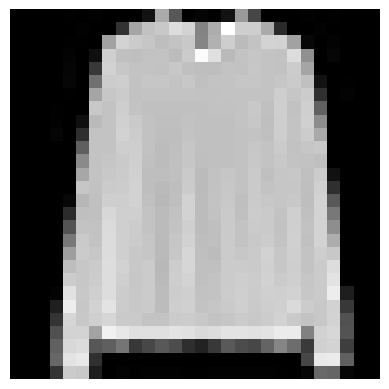

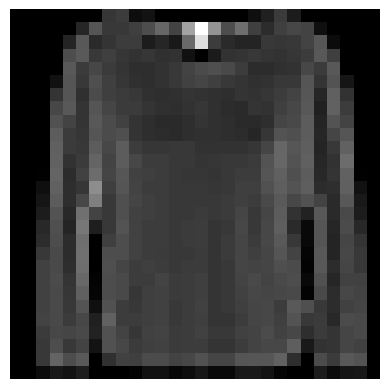

y -> y: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0575%


In [15]:
Q_dataset = x2y_ddib_asymptotic_neighbor_dataset[1][Q_point_indices]
T_dataset = x2y_ddib_asymptotic_neighbor_dataset[1]
plot_data_point(Q_dataset[0])
plot_data_point(T_dataset[0])

prob_bound_list = []
for Q_point in Q_dataset:
    prob_bound = cod_prob_bound(
        T_dataset,
        EPSILON,
        Q_point,
        "euclidean",
        N,
        P,
    )
    prob_bound_list.append(prob_bound)
prob_bound_list = np.array(prob_bound_list)
y2self_prob_bound = prob_bound_list.mean()

print(f"y -> y: P{{DMAX({N})<=(1+{EPSILON})DMIN({N})}}>={y2self_prob_bound:.4%}")


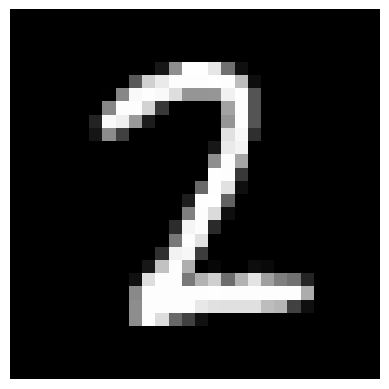

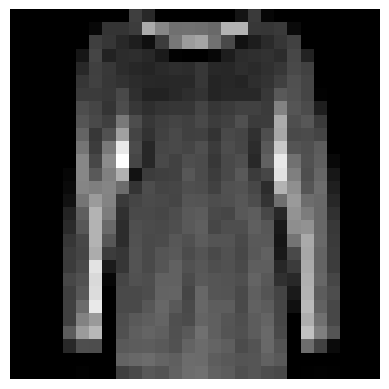

x -> y: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0062%


In [16]:
Q_dataset = x2y_ddib_asymptotic_neighbor_dataset[0][Q_point_indices]
T_dataset = x2y_ddib_asymptotic_neighbor_dataset[1]

plot_data_point(Q_dataset[3])
plot_data_point(T_dataset[3])

prob_bound_list = []
for Q_point in Q_dataset:
    prob_bound = cod_prob_bound(
        T_dataset,
        EPSILON,
        Q_point,
        "euclidean",
        N,
        P,
    )
    prob_bound_list.append(prob_bound)
prob_bound_list = np.array(prob_bound_list)
x2y_prob_bound = prob_bound_list.mean()
print(f"x -> y: P{{DMAX({N})<=(1+{EPSILON})DMIN({N})}}>={x2y_prob_bound:.4%}")


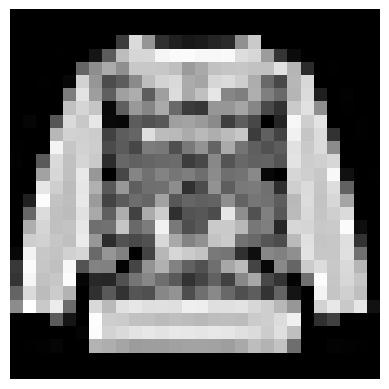

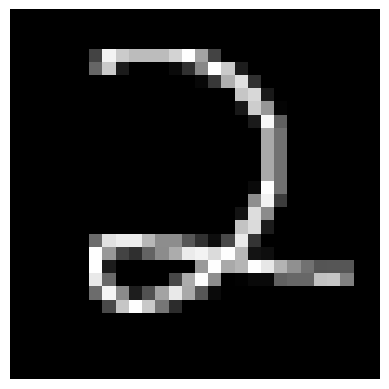

y -> x: P{DMAX(2)<=(1+0.25)DMIN(2)}>=70.7835%


In [17]:
Q_dataset = x2y_ddib_asymptotic_neighbor_dataset[1][Q_point_indices]
T_dataset = x2y_ddib_asymptotic_neighbor_dataset[0]

plot_data_point(Q_dataset[3])
plot_data_point(T_dataset[3])

prob_bound_list = []
for Q_point in Q_dataset:
    prob_bound = cod_prob_bound(
        T_dataset,
        EPSILON,
        Q_point,
        "euclidean",
        N,
        P,
    )
    prob_bound_list.append(prob_bound)
prob_bound_list = np.array(prob_bound_list)
y2x_prob_bound = prob_bound_list.mean()
print(f"y -> x: P{{DMAX({N})<=(1+{EPSILON})DMIN({N})}}>={y2x_prob_bound:.4%}")


In [18]:
for t in range(DIFFUSION_STEPS):
    for i, x in enumerate(x2y_ddib_asymptotic_neighbor_dataset[0]):
        x_next = add_ddim_noise_at_t_step(x, t, SCHEDULER)
        x2y_ddib_asymptotic_neighbor_dataset[1, i] = x_next

    Q_dataset = x2y_ddib_asymptotic_neighbor_dataset[0][Q_point_indices]
    T_dataset = x2y_ddib_asymptotic_neighbor_dataset[1]

    prob_bound_list = []
    for Q_point in Q_dataset:
        prob_bound = cod_prob_bound(
            T_dataset,
            EPSILON,
            Q_point,
            "euclidean",
            N,
        )
    prob_bound_list.append(prob_bound)
    prob_bound_list = np.array(prob_bound_list)
    prob_bound = prob_bound_list.mean()
    x2g_ddim_prob_bound_list.append(prob_bound)

    x2y_ddib_asymptotic_neighbor_dataset[0] = x2y_ddib_asymptotic_neighbor_dataset[1]

    print(f"x{t}->x{t+1}: P{{DMAX({N})<=(1+{EPSILON})DMIN({N})}}>={prob_bound:.4%}")


x0->x1: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0000%
x1->x2: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0000%
x2->x3: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0000%
x3->x4: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0000%
x4->x5: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0000%
x5->x6: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0000%
x6->x7: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0000%
x7->x8: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0000%
x8->x9: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.1482%
x9->x10: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.8540%
x10->x11: P{DMAX(2)<=(1+0.25)DMIN(2)}>=3.2937%
x11->x12: P{DMAX(2)<=(1+0.25)DMIN(2)}>=5.7781%
x12->x13: P{DMAX(2)<=(1+0.25)DMIN(2)}>=9.3265%
x13->x14: P{DMAX(2)<=(1+0.25)DMIN(2)}>=14.7150%
x14->x15: P{DMAX(2)<=(1+0.25)DMIN(2)}>=20.4128%
x15->x16: P{DMAX(2)<=(1+0.25)DMIN(2)}>=27.5670%
x16->x17: P{DMAX(2)<=(1+0.25)DMIN(2)}>=32.4547%
x17->x18: P{DMAX(2)<=(1+0.25)DMIN(2)}>=39.1900%
x18->x19: P{DMAX(2)<=(1+0.25)DMIN(2)}>=46.2895%
x19->x20: P{DMAX(2)<=(1+0.25)DMIN(2)}>=51.1265%
x20->x21: P{DMAX(2)<=(1+0.25)DMIN(2)}>=56.4447%
x21->x22: P{DMAX(2)<=(1+

  0%|          | 0/1000 [00:00<?, ?it/s]

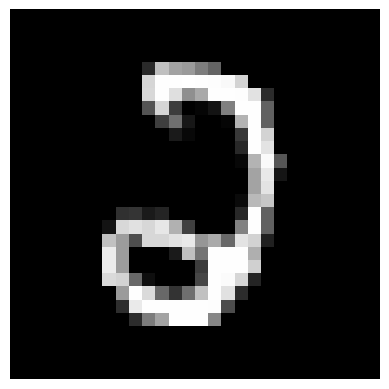

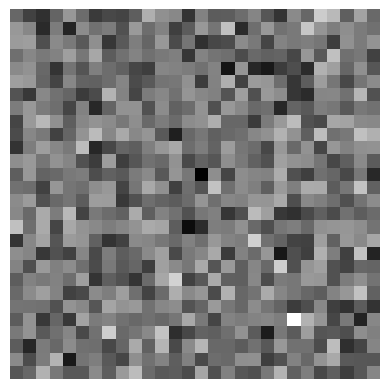

x -> g: P{DMAX(2)<=(1+0.25)DMIN(2)}>=92.0430%


In [19]:
for i in tqdm(range(len(dataset))):
    x2y_ddib_asymptotic_neighbor_dataset[0][i] = dataset[i][0]

Q_dataset = x2y_ddib_asymptotic_neighbor_dataset[0][Q_point_indices]
T_dataset = x2y_ddib_asymptotic_neighbor_dataset[1]

plot_data_point(Q_dataset[0])
plot_data_point(T_dataset[0])

prob_bound_list = []
for Q_point in Q_dataset:
    prob_bound = cod_prob_bound(
        T_dataset,
        EPSILON,
        Q_point,
        "euclidean",
        N,
        P,
    )
    prob_bound_list.append(prob_bound)
prob_bound_list = np.array(prob_bound_list)
x2g_prob_bound = prob_bound_list.mean()
print(f"x -> g: P{{DMAX({N})<=(1+{EPSILON})DMIN({N})}}>={x2g_prob_bound:.4%}")


In [20]:
for i in tqdm(range(len(dataset))):
    x2y_ddib_asymptotic_neighbor_dataset[0][i] = dataset[i][1]


  0%|          | 0/1000 [00:00<?, ?it/s]

In [21]:
for t in range(DIFFUSION_STEPS):
    for i, y in enumerate(x2y_ddib_asymptotic_neighbor_dataset[0]):
        y_prev = add_ddim_noise_at_t_step(y, t, SCHEDULER)
        x2y_ddib_asymptotic_neighbor_dataset[1, i] = y_prev

    Q_dataset = x2y_ddib_asymptotic_neighbor_dataset[1][Q_point_indices]
    T_dataset = x2y_ddib_asymptotic_neighbor_dataset[0]

    prob_bound_list = []
    for Q_point in Q_dataset:
        prob_bound = cod_prob_bound(
            T_dataset,
            EPSILON,
            Q_point,
            "euclidean",
            N,
        )
    prob_bound_list.append(prob_bound)
    prob_bound_list = np.array(prob_bound_list)
    prob_bound = prob_bound_list.mean()
    print(f"y{t + 1}->y{t}: P{{DMAX({N})<=(1+{EPSILON})DMIN({N})}}>={prob_bound:.4%}")
    g2y_ddim_prob_bound_list.insert(0, prob_bound)

    x2y_ddib_asymptotic_neighbor_dataset[0] = x2y_ddib_asymptotic_neighbor_dataset[1]


y1->y0: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0000%
y2->y1: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0000%
y3->y2: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0000%
y4->y3: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0000%
y5->y4: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0000%
y6->y5: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0000%
y7->y6: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0000%
y8->y7: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0000%
y9->y8: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0000%
y10->y9: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0000%
y11->y10: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0000%
y12->y11: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0000%
y13->y12: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0000%
y14->y13: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.3430%
y15->y14: P{DMAX(2)<=(1+0.25)DMIN(2)}>=2.5327%
y16->y15: P{DMAX(2)<=(1+0.25)DMIN(2)}>=6.1252%
y17->y16: P{DMAX(2)<=(1+0.25)DMIN(2)}>=12.0532%
y18->y17: P{DMAX(2)<=(1+0.25)DMIN(2)}>=19.6262%
y19->y18: P{DMAX(2)<=(1+0.25)DMIN(2)}>=27.5314%
y20->y19: P{DMAX(2)<=(1+0.25)DMIN(2)}>=32.8243%
y21->y20: P{DMAX(2)<=(1+0.25)DMIN(2)}>=41.2314%
y22->y21: P{DMAX(2)<=(1+0.2

  0%|          | 0/1000 [00:00<?, ?it/s]

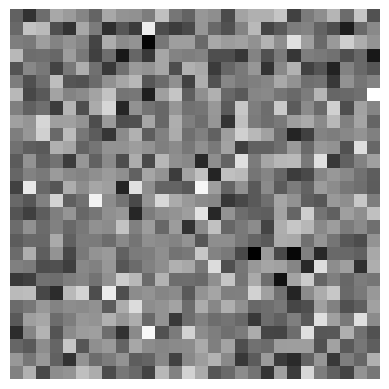

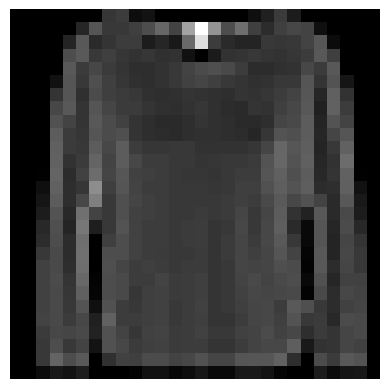

g -> y: P{DMAX(2)<=(1+0.25)DMIN(2)}>=73.5058%


In [22]:
for i in tqdm(range(len(dataset))):
    x2y_ddib_asymptotic_neighbor_dataset[1][i] = dataset[i][1]

Q_dataset = x2y_ddib_asymptotic_neighbor_dataset[0][Q_point_indices]
T_dataset = x2y_ddib_asymptotic_neighbor_dataset[1]

plot_data_point(Q_dataset[0])
plot_data_point(T_dataset[0])

prob_bound_list = []
for Q_point in Q_dataset:
    prob_bound = cod_prob_bound(
        T_dataset,
        EPSILON,
        Q_point,
        "euclidean",
        N,
        P,
    )
    prob_bound_list.append(prob_bound)
prob_bound_list = np.array(prob_bound_list)
g2y_prob_bound = prob_bound_list.mean()
print(f"g -> y: P{{DMAX({N})<=(1+{EPSILON})DMIN({N})}}>={g2y_prob_bound:.4%}")


#### Plot


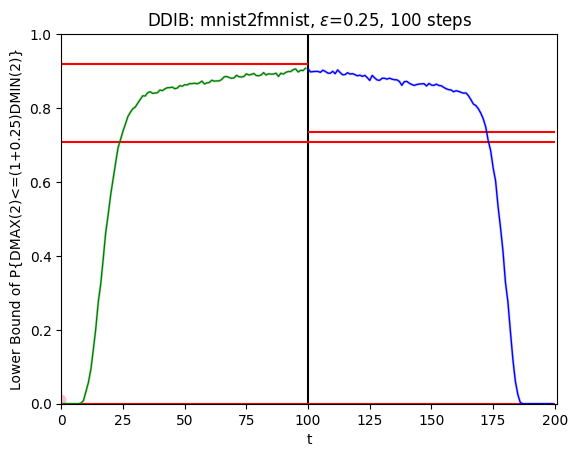

In [24]:
plt.vlines(DIFFUSION_STEPS, 0, 1, colors="black")


plt.hlines(x2g_prob_bound, 0, DIFFUSION_STEPS, colors="red")
plt.hlines(g2y_prob_bound, DIFFUSION_STEPS, DIFFUSION_STEPS * 2, colors="red")
plt.hlines(x2y_prob_bound, 0, DIFFUSION_STEPS * 2, colors="red")
plt.hlines(y2x_prob_bound, 0, DIFFUSION_STEPS * 2, colors="red")

plt.scatter(0, x2self_prob_bound, c="pink")
plt.scatter(0, y2self_prob_bound, c="pink")
# plt.hlines(x2g_ddim_prob_bound, 0, mid_step, colors="red")
# plt.hlines(g2y_ddim_prob_bound, mid_step, DIFFUSION_STEPS * 2, colors="red")

t = np.arange(0, DIFFUSION_STEPS)
plt.plot(t, x2g_ddim_prob_bound_list, color="green", lw=1)
plt.plot(t, x2g_ddim_prob_bound_list, color="green", lw=2, alpha=0.2)
plt.plot(t + DIFFUSION_STEPS, g2y_ddim_prob_bound_list, color="blue", lw=1)
plt.plot(t + DIFFUSION_STEPS, g2y_ddim_prob_bound_list, color="blue", lw=2, alpha=0.2)


plt.xlabel("t")
plt.ylabel(f"Lower Bound of P{{DMAX({N})<=(1+{EPSILON})DMIN({N})}}")

plt.xlim(0, DIFFUSION_STEPS * 2 + 1)
plt.ylim(0, 1)
plt.margins(x=0)
plt.title(f"DDIB: {DATASET}, $\epsilon$={EPSILON}, {DIFFUSION_STEPS} steps")
plt.show()

# TODO LIST

1. 数据集加载
   - [√] FMNIST, MNIST, USPS
   - [√] comic_faces_v1
2. 多种渐变方式
   - [√] 扩散(DDIM)：并无直接 X->Y 的分布转移渐变，只有 X->高斯->Y 分布。但高斯分布本身会造成严重距离聚集。
   - [√] Flow(插值)：X->Y 分布转移渐变，纯粹生成一般随机采样高斯噪声作为 X。
   - [] 薛定谔桥：同 Flow
3. []CoD 概率下界计算
   - [√] 直接
   - [√] 逐步
   - [] 选取节点：加噪 1000 步，选取个别节点
4. [√]画图
5. []级联 OT
